In [2]:
from __future__ import unicode_literals, division
import re
import sys
from tqdm import tqdm_notebook

In [3]:
# ! pip install tqdm --user 

In [4]:
import pandas as pd
import numpy as np
import spacy

import tensorflow as tf

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10,10)
sns.set()

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
from embedding import get_embedding
from config import Config
from data_utils import tokenize_sent

/home/u26008/.local/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


## POS Tags

In [8]:
nlp = spacy.load('en_core_web_sm')
def get_pos_tags(word_list):
    tags = []
    sent = ' '.join(word_list)
    doc = nlp(sent)
    [tags.append(token.tag_) for token in doc]
    return tags

In [9]:
get_pos_tags('i druuink tea'.split())

['PRP', 'VBP', 'NN']

# Get configurations

In [10]:
config = Config()
max_len = 70
embedding_size = config.embedding_size

In [11]:
path = '../train.csv'

In [12]:
data = pd.read_csv(path)
data = data[:100000]


In [13]:
columns = data.columns

In [14]:
columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [15]:
data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [16]:
data.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

# sequence lengths

In [17]:
data['seql_one'] = data['question1'].apply(lambda row: len(tokenize_sent(str(row).lower())))
data['seql_two'] = data['question2'].apply(lambda row: len(tokenize_sent(str(row).lower())))

In [18]:
data = data.loc[(data.seql_one != 0)  & (data.seql_two!=0) ]

In [19]:
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'seql_one', 'seql_two'],
      dtype='object')

# spliting data to train and dev

80% train data and 20% test data

In [20]:
split_ratio = 0.8

In [21]:
l = len(data)

In [22]:
train_length = int(l*split_ratio)

In [23]:
data.groupby('is_duplicate').count()

,id,qid1,qid2,question1,question2,seql_one,seql_two
is_duplicate,,,,,,,
0,62740,62740,62740,62740,62740,62740,62740
1,37254,37254,37254,37254,37254,37254,37254


# word2vec features


In [24]:
def get_sent_embedding(sent):
    sent = str(sent).lower().strip()
    vector = []
    counter = 0
    vector = [get_embedding(w) for w in tokenize_sent(sent)]
    return vector

In [25]:
# get_sent_embedding('dsfhgdsj sajkfgksdgf')

In [26]:
len(get_sent_embedding('i love reading'))

loading w2v


3

In [27]:
train_data = data[:train_length]


train_data['vec_1'] = train_data['question1'].apply(lambda row: get_sent_embedding(row))
train_data['vec_2'] = train_data['question2'].apply(lambda row: get_sent_embedding(row))

train_data_all = list(zip(train_data.vec_1, train_data.vec_2, 
                 train_data.seql_one, train_data.seql_two, 
                 train_data.is_duplicate))


/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [28]:
dev_data = data[train_length:]


dev_data['vec_1'] = dev_data['question1'].apply(lambda row: get_sent_embedding(row))
dev_data['vec_2'] = dev_data['question2'].apply(lambda row: get_sent_embedding(row))

dev_data_all = list(zip(dev_data.vec_1, dev_data.vec_2, 
               dev_data.seql_one, dev_data.seql_two, 
               dev_data.is_duplicate))


/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [29]:
len(dev_data)

19999

# Building and training Model

In [39]:
from model import Model
model = Model()

In [40]:
model.config.n_hidden = 128
model.config.lr = 0.001
model.config.batch_size = 64
model.config.n_layers =3
model.config.keep_prob = 1

In [41]:
tf.reset_default_graph()
model.build()

INFO:tensorflow:Summary name gradients/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel:0 is illegal; using gradients/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 instead.
INFO:tensorflow:Summary name variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel:0 is illegal; using variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 instead.
INFO:tensorflow:Summary name gradients/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias:0 is illegal; using gradients/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 instead.
INFO:tensorflow:Summary name variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias:0 is illegal; using variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 instead.
INFO:tensorflow:Summary name gradients/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel:0 is illegal; using gradients/lstm/bidirectional_rnn/fw/multi_rn

In [ ]:
model.train(train_data=train_data_all, dev_data=dev_data_all)

A Jupyter Widget

Nan in summary histogram for: opt/gradients/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_2/lstm_cell/bias_0
	 [[node opt/gradients/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_2/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:139) ]]

Caused by op 'opt/gradients/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_2/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho


Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pyth

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho


Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pyth

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho


Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pyth

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_1/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-python/vers

Nan in summary histogram for: opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0
	 [[node opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 (defined at /home/u26008/repos/quora_duplicates/model/model.py:140) ]]

Caused by op 'opt/variables/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0', defined at:
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/glob/intel-pytho

## Restore Model

In [46]:
model.restore_session(config.save_dir)

INFO:tensorflow:Restoring parameters from /home/u26008/repos/quora_duplicates/models_weights/


In [47]:
# tf.trainable_variables()

In [48]:
def get_score(model, vec_1, vec_2):
    s1 = len(vec_1)
    s2 = len(vec_2)
    return model.get_feed_dict(sent_1=[vec_1], 
                        sent_2=[vec_2], 
                        sent_1_len=[s1], 
                        sent_2_len=[s2],
                        label = None
                       )
    

In [49]:
def get_l2_score(model, vec1, vec2):
    return model.sess.run(model.l2, feed_dict=get_score(model, vec1, vec2))
    

## Test accuracy

In [ ]:
# get_score(model, dev_data.vec_1.values, dev_data.vec_2.values)

In [ ]:
# dev_data.head()

In [ ]:
dev_data['l2'] = dev_data.apply(lambda row: get_l2_score(model, row['vec_1'], row['vec_2']), axis=1)

In [ ]:
dev_data['l2'] = dev_data['l2'].apply(lambda x: x[0])

In [ ]:
no_dup_data = dev_data[dev_data['is_duplicate']==0]

In [ ]:
dup_data = dev_data[dev_data['is_duplicate']==1]

In [ ]:
no_dup_data.l2.hist(bins=50)
# no_dup_data.l2.mean()

In [ ]:
dup_data.l2.hist(bins=50)
# dup_data.l2.mean()

In [44]:
boundary = 0.7

In [45]:
(len(dup_data[dup_data.l2<boundary]) + len(no_dup_data[no_dup_data.l2>=boundary]))/len(dev_data)

0.6746337316865844

##  Train Accuracy

In [50]:
train_data['l2'] = train_data.apply(lambda row: get_l2_score(model, row['vec_1'], row['vec_2']), axis=1)

/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [51]:
train_data['l2'] = train_data['l2'].apply(lambda x: x[0])

/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [58]:
no_dup_data = train_data[train_data['is_duplicate']==0]

In [59]:
dup_data = train_data[train_data['is_duplicate']==1]

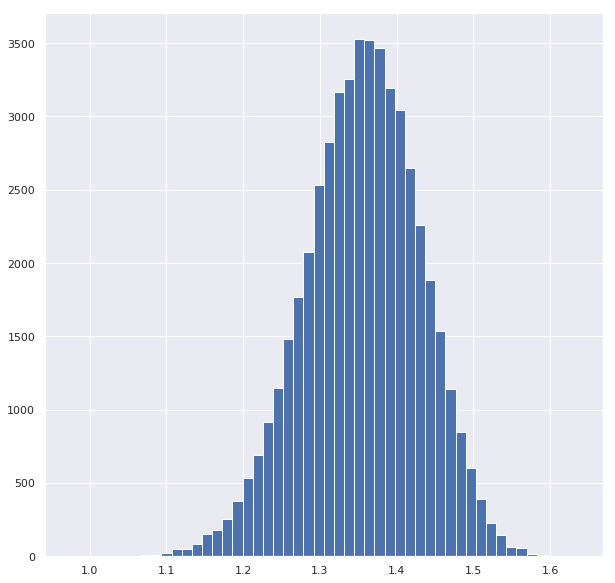

In [60]:
no_dup_data.l2.hist(bins=50)
# no_dup_data.l2.mean()

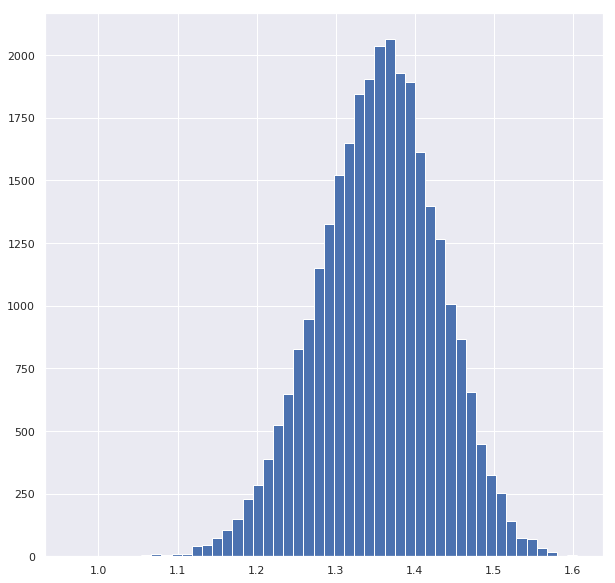

In [61]:
dup_data.l2.hist(bins=50)
# dup_data.l2.mean()

In [62]:
boundary = 0.5

In [63]:
(len(dup_data[dup_data.l2<boundary]) + len(no_dup_data[no_dup_data.l2>=boundary]))/len(train_data)

0.6274517157322332